In [1]:
# TODO: Try diagonal and uniform correlations (totally uncorrelated and correlated) (think about the circle)
# TODO: Make sure we're finding global minimum
# TODO: With and without portfolio
# TODO: Paramters - factors, dates, correlation

# TODO: Remove first principal component... make it beta neutral

In [2]:
from typing import Optional, List
from importlib import reload

import pandas as pd

from data import build_dataset_with_composites #, get_yf_returns, get_factor_master, get_portfolios, get_factor_data, get_yf_data, cumulate_returns
# from stats import get_volatility_set, get_correlation_set
from util import xr_pct_change #, safe_reindex

from corr_mds import *

In [3]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

In [4]:
# # def get_factor_data_port(halflifes: Optional[List[int]] = None) -> xr.Dataset:
# # if halflifes == None:
# #     halflifes = [21, 63, 126, 252, 512]

# factor_master = get_factor_master(sheet_name='read')
# asset_list = factor_master.loc[factor_master['composite'] == 0].index.to_list()
# portfolios = get_portfolios().pipe(safe_reindex, factor_master).fillna(0).loc[asset_list]


In [5]:
# def build_dataset_with_composites(halflifes: List[int]) -> xr.Dataset:
#     # Here `assets` refer to factors built from single security (basis vectors)
#     # Here `portfolios` refer to factors built from `assets`
    
#     factor_master = get_factor_master(sheet_name='read')
#     asset_list = factor_master.loc[factor_master['composite'] == 0].index.to_list()
#     asset_data = get_yf_returns(asset_list)
#     asset_ret = asset_data['ret'].to_pandas()
    
#     portfolios_weights = get_portfolios().pipe(safe_reindex, factor_master).fillna(0).loc[asset_list]  
#     portfolios_ret = asset_ret @ portfolios_weights

#     factor_data = xr.Dataset()
#     factor_data['ret'] = pd.concat([asset_ret, portfolios_ret], axis=1).rename_axis(columns='asset')
#     # factor_data['ret'] = (pd.concat([asset_ret['MWTIX'], portfolios_ret, asset_ret.drop(columns=['MWTIX'])], axis=1).rename_axis(columns='asset'))
#     factor_data['vol']   = get_volatility_set(factor_data['ret'], halflifes)
#     factor_data['corr']  = get_correlation_set(factor_data['ret'], halflifes)
#     factor_data['cret']  = factor_data['ret'].cumsum(dim='date')

#     factor_data['asset'].attrs = factor_master.T.to_dict()

#     return factor_data

In [6]:
halflifes = [21, 63, 126, 512]
factor_data2 = build_dataset_with_composites(halflifes)

[*********************100%%**********************]  57 of 57 completed


In [7]:
# mds_ts = (mds_ts_df(factor_data2.corr, transformation='rotate_initial', start_date='2024')
#             .reset_index()
#             .join(factor_master, on='asset')
#             .assign(date = lambda df: df['date'].astype(str))
#             # .assign(size = lambda df: df['hyper_factor'].mul(1).add(.5).astype('float'))
#             .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
#             .replace('MWTIX', 'TCW')
#             )


In [33]:
def get_marker_size(ds):

    # date = '2024-11-01'
    date_latest = ds.date.max().values
    vol_short = ds['vol'].sel(date=date_latest, vol_type=21)
    vol_long  = ds['vol'].sel(date=date_latest, vol_type=126)
    vol_ratio = vol_short / vol_long
    vol_ratio.to_pandas() #.rename('vol_ratio') # .sort_values(ascending=False)

    factor_master = pd.DataFrame(ds.asset.attrs).T

    df = factor_master[['hyper_factor']].join(vol_ratio.to_pandas().rename('vol_ratio'))
    # df['vol_ratio'].sort_values(ascending=False).mul(5).clip(upper=10)


    df['marker_size'] = (df['vol_ratio'].add(1).mul(5).clip(upper=10) #, lower=1)
                         .where(df['hyper_factor'] != 1, 15)
                         )
    date_prior = factor_data2.date.sel(date=slice(None, date_latest)).isel(date=-21).values
    cret_t1 = ds['cret'].sel(date=date_latest)
    cret_t0 = ds['cret'].sel(date=date_prior, method='nearest')
    ret = ((cret_t1/cret_t0)-1).to_pandas()
    
    df['marker_symbol'] = ret.map(lambda x: 'circle' if x > 0 else 'triangle-up')

    return df['marker_size'] #, 'marker_symbol']]
# .to_frame().style

# df.assign(marker_size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
get_marker_size(factor_data2) #.sort_values(ascending=False).to_frame().style



SPY            15.000000
IWM             9.310686
MDY             9.380581
RSP             9.327258
QQQ             9.764143
                 ...    
TRUMP          15.000000
FED            15.000000
AI             15.000000
GEOPOLITICS    15.000000
2s10s          15.000000
Name: marker_size, Length: 62, dtype: float64

In [13]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *



def run_mds(ds, transformation, dates, start_date, tick_range, animate=False, drop_composites=True, drop_trump=False, **kwargs):
    # TODO: Pass in full dataset to extract corr, factor_master, and vol (for sizing)
    
    # TODO: Pass in a list of dates or take all dates from the dataarray
    # TODO: Make clear the ordering of dates (use sorted function)
    # t0, t1, t2 = dates
    # (t0, t1, t2) = factor_data2.date.values[[-1, -21-1, -63-1]]

    
    transformation_type = {None:             'No rotation', 
                           'rotate':         'Rotate SPY to x-axis each day', 
                           'normalize':      'SPY transformed to (1, 0)',
                           'rotate_initial': '' #'Rotate SPY to x-axis today'
                           }

    factor_master = pd.DataFrame(ds.asset.attrs).T
    
    marker_size = get_marker_size(ds) #.rename('size')
    
    mds_ts = (mds_ts_df(ds.corr, transformation=transformation, start_date=start_date, **kwargs)
                .reset_index()
                .join(factor_master, on='asset')
                .assign(date = lambda df: df['date'].astype(str))
                # .assign(size = lambda df: df['hyper_factor'].mul(1).add(.5).astype('float'))
                # .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))
                # .assign(size = lamdba df: marker_size)
                .join(marker_size, on='asset')
                .replace('MWTIX', 'TCW')
                )
    
    if drop_composites:
        mds_ts = mds_ts.query('composite == 0')

    if drop_trump:
        mds_ts = mds_ts.query('asset != "TRUMP"')
    
    if animate:
        fig = draw_mds_ts(mds_ts, tick_range=tick_range)
        fig.update_traces(textfont_color = 'lightgray')
    
    else:
        # print(dates)
        # print(dates[0])
        mds_latest = mds_ts[mds_ts['date'] == dates[0]].drop(columns='date')
        fig = draw_mds_ts(mds_latest, tick_range=tick_range)
        
        for i in range(len(dates) - 1):
            fig = add_whiskers(fig, mds_ts, dates[i], dates[i + 1])
        # fig = add_whiskers(fig, mds_ts, t0, t1)
        # fig = add_whiskers(fig, mds_ts, t1, t2)
        fig.update_layout(legend_title_text=None, title=f'{transformation_type[transformation]}')
        
                
        def get_trace_color(trace, legendgroup):
            return trace.marker.color if trace.legendgroup in legendgroup else 'lightgray'
        
        
        asset_class_list = ['Theme', 'Portfolio']
        fig.for_each_trace(lambda t: t.update(textfont_color = get_trace_color(t, asset_class_list)))
    
    # r = sqrt(2)/2
    # r = 0.8
    # fig.add_shape(
    #     type="circle",
    #     xref="x", yref="y",
    #     x0=-r, y0=-r, x1=r, y1=r,
    #     line_color='lightgray', line_width=.5,
    #     )
    
    return fig

# mds_previous = mds_ts[mds_ts['date'] == t1].drop(columns='date')
# fig_previous = (draw_mds_ts(mds_previous, tick_range=1.5)
#                 .update_traces(text=None,  opacity=0.3) # marker_size=5,
#                 .update_layout(showlegend=False))
# for trace in fig_previous.data:
#     trace.showlegend = False
#     fig.add_trace(trace)

# for trace in fig.data:
#     if trace.mode == 'lines':
#         for marker_trace in fig.data:
#             if marker_trace.mode == 'markers+text' and marker_trace.name == trace.legendgroup:
#                 trace.update(line=dict(color=marker_trace.marker.color))
#                 break


In [14]:
# color_dict = {a: b for a, b in zip(factor_master.asset_class.unique(), color_sequence)}
# color_dict['Portfolio'] = 'black'
# color_dict['Composite'] = 'darkred'
# color_dict


In [15]:
# import plotly.io as pio
# color_sequence = pio.templates['plotly_white']['layout']['colorway']
# color_sequence
# # pio.templates

In [16]:

# sorted(dates_t1, reverse=True)

In [17]:
# dates_t1.sort()
# dates_t1.sort(reverse=True)
# dates_t1

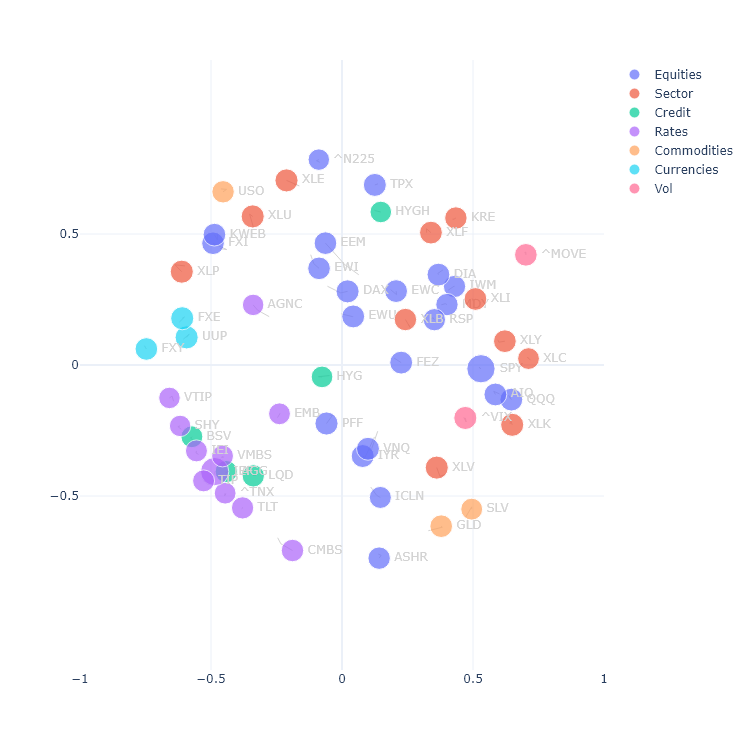

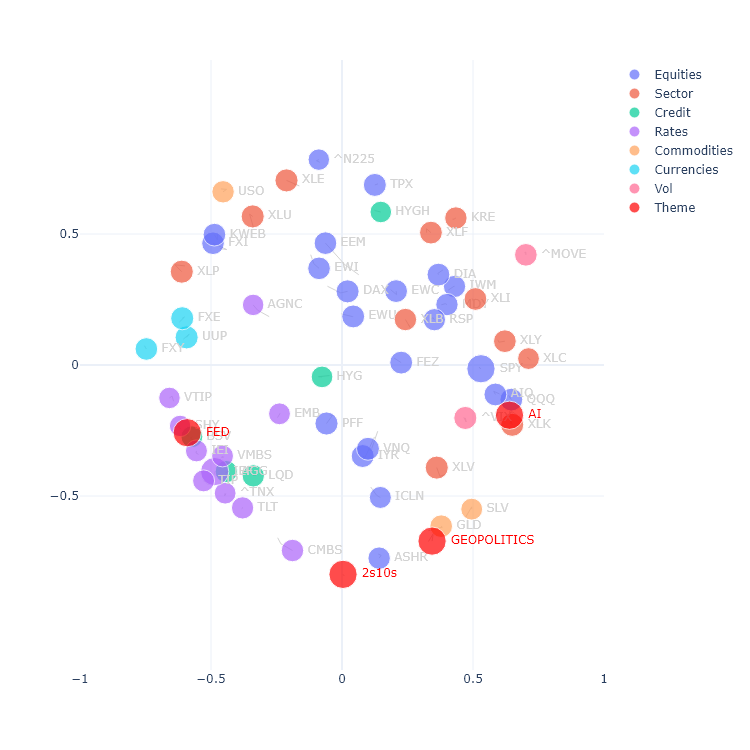

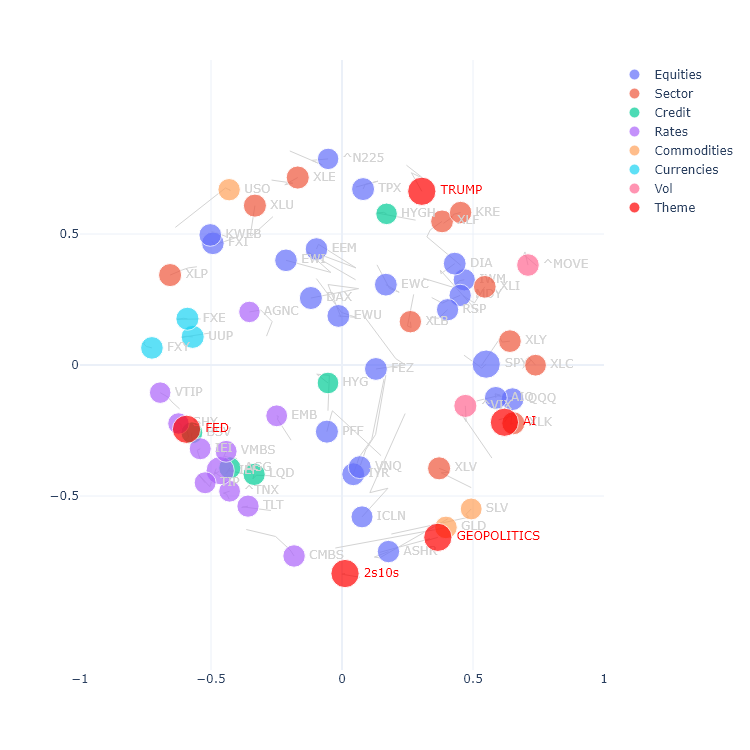

In [29]:
from importlib import reload
import corr_mds
reload(corr_mds)
from corr_mds import *

# TODO: Do the args work?!

args = {'random_state': 42, 
        'n_init': 100}

dates_t1 = ['2024-11-20', '2024-10-18', '2024-08-16', '2024-01-05']
dates_t1 = ['2024-12-11', '2024-10-18', '2024-08-16', '2024-01-05']
dates_t0 = ['2024-10-31', '2024-09-30', '2024-08-30']

# TCW as of 2024-10-31
# TCW + 3 themes as of 2024-10-31
# TCW + 3 themes + trump as of 2024-11-18

fig = (run_mds(factor_data2, 
               transformation='rotate_initial', 
               dates=dates_t0,
               start_date='2024', 
               tick_range=1,
               drop_composites=True,
               drop_trump=True,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_tcw.png')

fig = (run_mds(factor_data2, 
               transformation='rotate_initial', 
               dates=dates_t0,
               start_date='2024', 
               tick_range=1,
               drop_composites=False,
               drop_trump=True,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_theme.png')

fig = (run_mds(factor_data2, 
               transformation='rotate_initial', 
               dates=dates_t1,
               start_date='2024', 
               tick_range=1,
               drop_composites=False,
               drop_trump=False,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show(renderer='png')
fig.write_image('corr_trump.png')




In [19]:
# fig.for_each_trace(lambda t: t.update(textfont_color = t.marker.color if t.marker.size == 10 else 'lightgray'))
# fig.show(renderer='png')

In [20]:
# fig.for_each_trace(lambda t: print(t.marker.size if t.marker.size is not None else None))

In [21]:
# fig.for_each_trace(lambda t: t.update(textfont_color = (t.marker.color if t.legendgroup in ['Theme', 'Portfolio'] else 'lightgray'))) # t.legendgroup
# # fig.for_each_trace(lambda t: print(t.legendgroup, t.marker.color)) # t.legendgroup
# fig.update_layout(title='')
# fig.show(renderer='png')


In [22]:
factor_data2.date.sel(date=slice('2020', None)).values

array(['2020-01-02T00:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-01-06T00:00:00.000000000', ...,
       '2025-02-10T00:00:00.000000000', '2025-02-11T00:00:00.000000000',
       '2025-02-12T00:00:00.000000000'], dtype='datetime64[ns]')

In [34]:
args = {'random_state': 42, 
        'n_init': 100}

# dates_t1 = ['2024-11-20', '2024-10-18', '2024-08-16']
# dates_t0 = ['2024-10-31', '2024-09-30', '2024-08-30']

dates_t1 = ['2024-11-20', '2024-10-18', '2024-08-16', '2024-01-05']
dates_t1 = ['2024-12-11', '2024-10-18', '2024-08-16', '2024-01-05']
dates_t0 = ['2024-10-31', '2024-09-30', '2024-08-30']
dates = factor_data2.date.sel(date=slice('2020', None)).values


fig = (run_mds(factor_data2.resample(date='W').last(), 
               transformation='rotate_initial', 
               dates=dates,
               start_date='2020', 
               tick_range=1,
               animate=True,
               drop_composites=True,
               drop_trump=False,
               **args)
    #    .update_layout(title=f"random_state={args['random_state']}, n_init={args['n_init']}")
       )
fig.show()
# fig.write_html('corr_animation.html')

c:\Users\bkrai\Source\risk\corr_mds.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# factor_data2.corr.sel(date='2024-11-18', corr_type=63).to_pandas().style

In [ ]:
# reload(corr_mds)
# run_mds(factor_data2.corr, transformation=None, start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate', start_date='2004', tick_range='auto').show(renderer='png')
# run_mds(factor_data2.corr, transformation='rotate_initial', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='rotate_list', start_date='2004', tick_range='auto').show(renderer='png')
# # run_mds(factor_data2.corr, transformation='normalize', start_date='2004', tick_range=1).show(renderer='png')
# # fig.show(renderer='png')


# Market Feedback

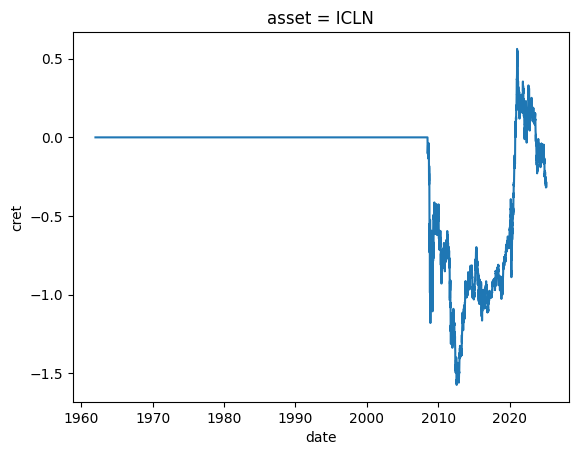

In [24]:
factor_data2.cret.sel(asset='ICLN').plot()

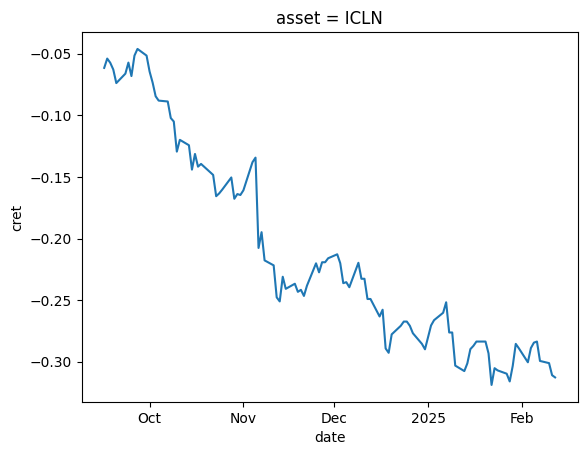

In [35]:
xr_pct_change(factor_data2.cret.sel(asset='ICLN'), dim='date', periods=21)

factor_data2.cret.sel(asset='ICLN', date=slice('2024-9-14', None)).plot()

In [27]:
def accumulate(da_ret, t0, t1, dim='date'):
    # return (da_ret.sel(date=slice(t0, t1))+1).cumprod('date')-1
    return (da_ret.sel({dim: slice(t0, t1)})+1).cumprod(dim) #-1

t0 = '2024-10-14'
t1 = '2024-11-14'

accumulate(factor_data2.ret, t0, t1).to_pandas()


# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()

asset,SPY,IWM,MDY,RSP,QQQ,DIA,XLK,XLI,XLF,KRE,...,UUP,FXE,FXY,^VIX,^MOVE,TRUMP,FED,AI,GEOPOLITICS,2s10s
date,,,,,,,,,,,,,,,,,,,,,
2024-10-14,1.008178,1.007367,1.006007,1.007338,1.008391,1.005038,1.013041,1.005996,1.006235,1.007927,...,1.003122,0.997523,0.995801,0.962854,1.000000,1.018855,0.998874,1.003416,0.993745,1.000099
2024-10-15,1.000345,1.008180,1.003368,1.002779,0.994913,0.997224,0.990772,0.998266,1.008385,1.018956,...,1.003816,0.995740,0.999031,1.008798,1.073943,1.070029,1.000127,0.982211,0.985958,1.003347
2024-10-16,1.004693,1.024767,1.012517,1.009561,0.995034,1.004642,0.993848,1.005996,1.020856,1.032914,...,1.006590,0.993362,0.996124,0.956989,1.028615,1.108326,1.001502,0.981351,0.988437,1.002564
2024-10-17,1.004779,1.021965,1.013489,1.007949,0.995723,1.008677,0.996881,1.003107,1.023651,1.041875,...,1.009712,0.990588,0.992571,0.934018,1.030978,1.118261,0.999499,0.980100,0.993627,1.000643
2024-10-18,1.008644,1.019841,1.013819,1.010951,1.002250,1.009468,1.000433,1.006141,1.023866,1.027744,...,1.006937,0.993956,0.998062,0.881232,1.039335,1.097514,1.000988,0.990326,0.997298,0.998512
2024-10-21,1.006988,1.003796,1.002118,1.002335,1.004176,1.001838,1.005112,1.002601,1.015696,0.997587,...,1.011446,0.989597,0.989180,0.897850,1.088461,1.079824,0.997096,0.991551,1.000223,0.996415
2024-10-22,1.006453,1.000000,0.995642,0.997832,1.005270,1.001698,1.004073,0.990464,1.013761,1.010167,...,1.012487,0.987615,0.987565,0.889541,1.091078,1.077054,0.996975,0.989861,1.014268,0.995940
2024-10-23,0.997257,0.990871,0.989566,0.994553,0.989865,0.992015,0.989688,0.987574,1.012900,1.010856,...,1.015956,0.987021,0.977552,0.940371,1.089305,1.086303,0.995347,0.974353,1.003627,0.995969
2024-10-24,0.999413,0.993040,0.991476,0.994775,0.997892,0.988795,0.992591,0.980783,1.013761,1.016026,...,1.012140,0.990786,0.982397,0.932551,1.076053,1.080174,0.996342,0.983693,1.007746,0.996306


In [37]:
from util import xr_pct_change

date_latest = pd.to_datetime(factor_data2.date.max().item())
date_latest = '2024-11-14'
vol_type = 63

vol = factor_data2.vol.sel(date=date_latest, vol_type=vol_type).to_series()
# ret = factor_data.ret.sel(date=date_latest).to_series()
ret = xr_pct_change(factor_data2.cret, dim='date', periods=21).sel(date=date_latest).to_series().rename('ret').mul(100)
factor_master = pd.DataFrame(factor_data2.asset.attrs).T

df = pd.concat([ret, vol, factor_master], axis=1).reset_index()

fig_format = {'template': 'plotly_white', 'height': 750, 'width': 750}
fig = (px.scatter(df, x='vol', y='ret', color='asset_class', text='index', **fig_format)
       .update_traces(textposition='middle right', 
                      textfont_color='lightgray')
       .update_layout(# xaxis_title=None,
                      # yaxis_title=None,
                      # xaxis_showticklabels=False,
                      # yaxis_showticklabels=False,
                      # xaxis_showgrid=False,
                      # yaxis_showgrid=False,
                      xaxis_showline=False,
                      yaxis_showline=False,
                      legend_title_text=None,
                      )
       )

# fig.show(renderer='png')
fig.show()

<Axes: xlabel='date'>

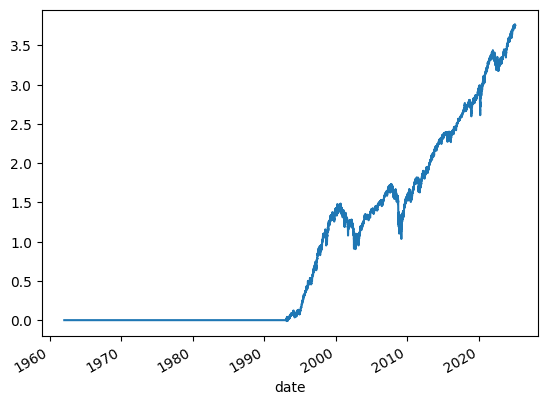

In [38]:
factor_data2['cret'].to_pandas()['SPY'].plot()

In [ ]:

# ds1 = factor_data2.sel(asset='SPY')
# ds1.ret.to_pandas().sort_index(ascending=False).to_clipboard()
# ((ds1.ret+1).cumprod('date')-1).to_pandas().sort_index(ascending=False).to_clipboard()
# xr_pct_change(((ds1.ret+1).cumprod('date')-1), dim='date', periods=1).to_pandas().sort_index(ascending=False).to_clipboard()

# # xr_pct_change(((factor_data2.ret.sel(asset='SPY')+1).cumprod('date')-1), dim='date', periods=1).to_pandas().to_clipboard()

# Scale by vol

In [ ]:
# factor_data2['vol'].

In [39]:
def get_vol_ratio(vol, vol_type_short_term, vol_type_long_term):
    vol_short = vol.sel(vol_type=vol_type_short_term)
    vol_long = vol.sel(vol_type=vol_type_long_term)
    vol_ratio = vol_short / vol_long
    return vol_ratio

In [ ]:
get_marker_size(ds, )
.assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 3).astype('float'))

In [ ]:
get_marker_size(factor_data2)

# Cum Ret

In [ ]:
from data import *

factor_master = get_factor_master(sheet_name='read')
asset_list = factor_master.loc[factor_master['composite'] == 0].index.to_list()
asset_data = get_yf_returns(asset_list)
asset_ret = asset_data['ret'].to_pandas()

portfolios_weights = get_portfolios().pipe(safe_reindex, factor_master).fillna(0).loc[asset_list]  
portfolios_ret = asset_ret @ portfolios_weights

factor_data = xr.Dataset()
factor_data['ret'] = pd.concat([asset_ret, portfolios_ret], axis=1).rename_axis(columns='asset')
# factor_data['ret'] = (pd.concat([asset_ret['MWTIX'], portfolios_ret, asset_ret.drop(columns=['MWTIX'])], axis=1).rename_axis(columns='asset'))
factor_data['vol']   = get_volatility_set(factor_data['ret'], halflifes)
factor_data['corr']  = get_correlation_set(factor_data['ret'], halflifes)
factor_data['cret']  = cumulate_returns(factor_data['ret'])

factor_data['asset'].attrs = factor_master.T.to_dict()


In [66]:
# factor_data['ret'].cumsum(dim='date')
factor_data['ret'].cumsum(dim='date', skipna=True).to_pandas().to_clipboard()

In [ ]:
(factor_data['ret']
 .cumsum(dim='date')
 .where(~factor_data['ret'].isnull(), np.nan)
 .ffill(dim='date')
 .to_pandas().to_clipboard()
 )